# Text Similarity Methods

When attempting to perform information retreival in the form of text matching it is important to consider two core ideas:

1. Lexical Similarity
2. Semantic Similarity.

The former involves discovering text pairs that have the same meaning, even when none of the words in the text pairs are the same. This contextual understanding is what represents a good target.

## Get a Sample Dataset - Amazon Reviews

In [1]:
import pandas as pd

In [12]:
df = pd.read_json('../../data/amazon-electronics-reviews.json', lines=True)
df = df[['reviewText']]
df.head(2)

## Method #1 - Jaccard Similarity

This represents typically lemmatising the words in the text pairs and calculating the outcome based on the lexical similarity. This would fail in cases such as the below:

Sentence 1: President greets the press in Chicago

Sentence 2: Obama speaks in Illinois

These pairs represent the same intent, but would score poorly using the Jaccard score.

## Define Contextual Input Test Pair Based on Above Insights

In [1]:
ss1 = 'The president greets the press in Chicago'
ss2 = 'Obama speaks to the media in Illinois'

## Method 2 - Cosine Similarity - Count Vectors

In [3]:
# packages
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return cosine

cosine_distance_countvectorizer_method(ss1 , ss2)\

Similarity of two sentences are equal to  37.8 %


0.6220355269907728

### Outcome

This method focuses only on the lexicon, not the context of words, which leads to a large cosine score. We want to see a score close to 0.

## Method 3 - Pre Trained Word Embeddings

For Example, ‘President’ vs ‘Prime minister’, ‘Food’ vs ‘Dish’, ‘Hi’ vs ‘Hello’ should be considered similar. For this, converting the words into respective word vectors, and then, computing the similarities can address this problem.

### Text Cleaning Method

In [12]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pandas as pd

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()
    
    # TODO - Add Stemmer / Lemma

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Load Glove Model

In [6]:
gloveFile = "../../data/glove.6B.100d.txt"
import numpy as np

def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

model = loadGloveModel(gloveFile)

Loading Glove Model
Done. 400001  words loaded!


Show the 100 values within the vector representing 'hello' as an example.

In [9]:
model['hello']

array([ 0.26688  ,  0.39632  ,  0.6169   , -0.77451  , -0.1039   ,
        0.26697  ,  0.2788   ,  0.30992  ,  0.0054685, -0.085256 ,
        0.73602  , -0.098432 ,  0.5479   , -0.030305 ,  0.33479  ,
        0.14094  , -0.0070003,  0.32569  ,  0.22902  ,  0.46557  ,
       -0.19531  ,  0.37491  , -0.7139   , -0.51775  ,  0.77039  ,
        1.0881   , -0.66011  , -0.16234  ,  0.9119   ,  0.21046  ,
        0.047494 ,  1.0019   ,  1.1133   ,  0.70094  , -0.08696  ,
        0.47571  ,  0.1636   , -0.44469  ,  0.4469   , -0.93817  ,
        0.013101 ,  0.085964 , -0.67456  ,  0.49662  , -0.037827 ,
       -0.11038  , -0.28612  ,  0.074606 , -0.31527  , -0.093774 ,
       -0.57069  ,  0.66865  ,  0.45307  , -0.34154  , -0.7166   ,
       -0.75273  ,  0.075212 ,  0.57903  , -0.1191   , -0.11379  ,
       -0.10026  ,  0.71341  , -1.1574   , -0.74026  ,  0.40452  ,
        0.18023  ,  0.21449  ,  0.37638  ,  0.11239  , -0.53639  ,
       -0.025092 ,  0.31886  , -0.25013  , -0.63283  , -0.0118

### Get the similarity score

In [22]:
import scipy

def cosine_distance_wordembedding_method(s1, s2):
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')
    return cosine
    
cosine_distance_wordembedding_method(ss1, ss2)  

Word Embedding method with a cosine distance asses that our two sentences are similar to 77.15 %


0.22852704995563478

This showcases for this example a signficant improvement in match quality using word embeddings.

### Let's visualise the embeddings...

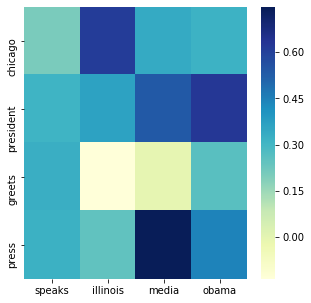

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def cosine_distance_between_two_words(word1, word2):
    return (1 - scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def heat_map_matrix_between_two_sentences(s1,s2):
    df = calculate_heat_matrix_for_two_sentences(s1,s2)
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    return ax_blue

heat_map_matrix_between_two_sentences(ss1,ss2)

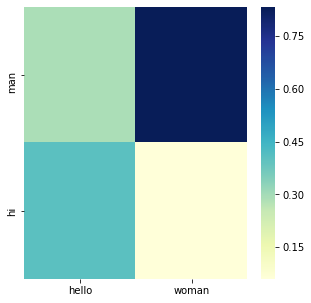

In [18]:
heat_map_matrix_between_two_sentences('hi, man','hello, woman')

## Resources

- https://medium.com/@adriensieg/text-similarities-da019229c894
- https://github.com/adsieg/text_similarity
- https://nlp.stanford.edu/projects/glove/
- https://www.cs.toronto.edu/~lczhang/360/lec/w06/w2v.html
- http://nlp.town/blog/sentence-similarity/